In [1]:
import pandas as pd
import scipy.spatial.distance as sci_dist
import matplotlib
# matplotlib.use('QtAgg')
import seaborn as sns
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
Image.MAX_IMAGE_PIXELS = None
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import os
import sys
np.random.seed(0)
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

tools_path = '../helperScripts/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

# data_folder = '/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_2/exports'
# cell_by_gene_path = data_folder + '/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv'
# transcripts_path = data_folder + '/decode_1_withcoordinates.csv'
# coords_path = data_folder + '/segmentation_1_nuclei_cellattributes.csv'
# region_data = '/Users/YaelHeyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/processedData/Region_Data_with_Minimal_Values.csv'
# Define file paths

data_folder = tools.roi_file_paths['dish_roi2']['out_path']
# data_folder = '/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_2/exports'
region_data_path = '../extractedData/in_vitro/Region_Data_with_Minimal_Values.csv'
# region_data_path = '/Users/YaelHeyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/processedData/Region_Data_with_Minimal_Values.csv'
cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.2thresh.csv')
data_output_folder = '../extractedData/in_vitro'
plot_output_folder = '../graphs'

output_folder = data_folder + '/processedData'
cell_by_gene = pd.read_csv(cell_by_gene_path)


In [2]:
pixel2um = 107.11 / 1000000  # Convert pixel to micrometers
combined_df = pd.DataFrame()
region_data = pd.read_csv(region_data_path)
for j in range(1,4):  # Adjust range as needed
    # Dynamically construct the path
    data_folder = tools.roi_file_paths[f'dish_roi{j}']['out_path']
    # data_folder = f"/Users/yaelheyman/RajLab Dropbox/Yael Heyman/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_{j}/exports"
    cell_by_gene_path = os.path.join(data_folder, 'cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
    print(data_folder)
    # Load the cell by gene data
    cell_by_gene = pd.read_csv(cell_by_gene_path, index_col=0)
        # Get reference X and Y from region_data as scalar values
    ref_x = region_data.loc[region_data['Region'] == f"Region {j}", "Min X (mm)"].iloc[0]
    ref_y = region_data.loc[region_data['Region'] == f"Region {j}", "Min Y (mm)"].iloc[0]
    
    # Correct the coordinates
    cell_by_gene['center_x'] = (cell_by_gene['center_x'] * pixel2um + ref_x)*1000
    cell_by_gene['center_y'] = (cell_by_gene['center_y'] * pixel2um + ref_y)*1000
    # Adjust the cell_id to make them unique across regions
    cell_by_gene['cell_id'] = cell_by_gene['cell_id'] + j * 100000
    
    # Concatenate to the combined DataFrame
    combined_df = pd.concat([combined_df, cell_by_gene], ignore_index=True)

/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_1/exports
/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_2/exports/
/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/roi_3/exports/


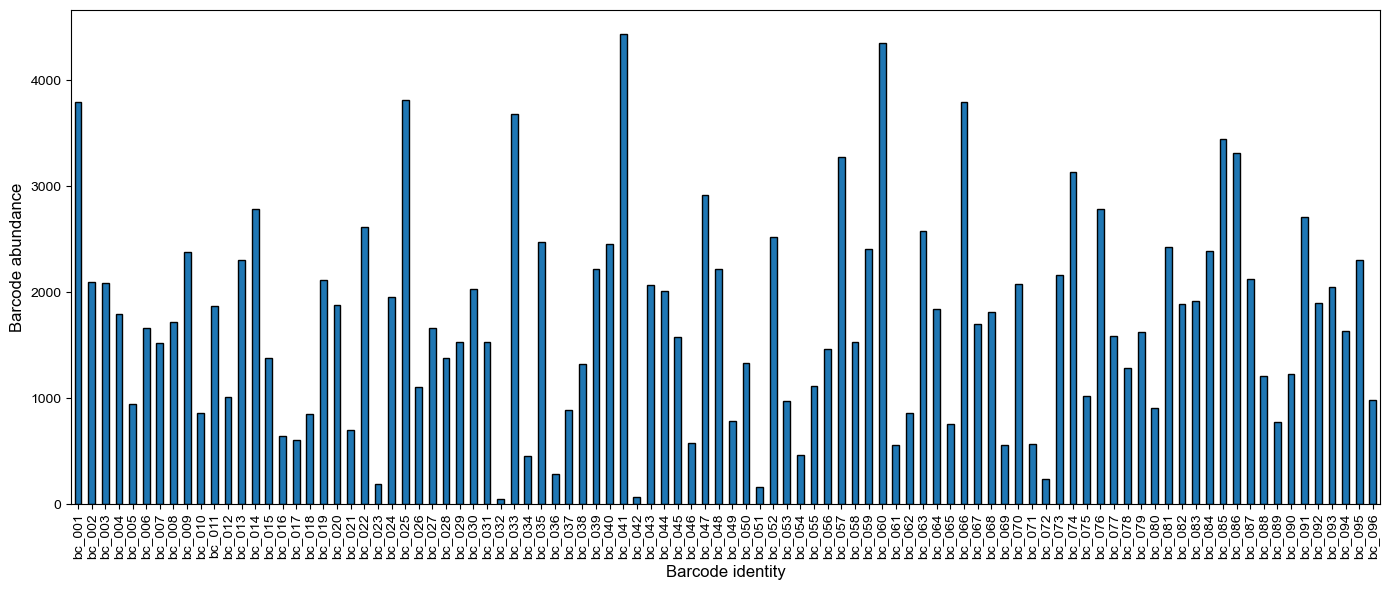

In [3]:

import ast
from collections import Counter
# Load the data
df = combined_df 

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
# Drop empty barcode entries (e.g., '[]' or NaN)
called = df['called_barcodes'].dropna()
called = called[called != '[]']

# Convert string representation of list to actual Python list using ast.literal_eval
barcode_lists = called.apply(ast.literal_eval)

# Flatten all barcodes into one list
all_barcodes = [barcode for sublist in barcode_lists for barcode in sublist]

# Count frequency of each barcode
barcode_counts = Counter(all_barcodes)
barcode_series = pd.Series(barcode_counts).sort_values(ascending=False)
# Sort by numeric value in 'bc_###'
barcode_series = barcode_series.sort_index(key=lambda x: x.str.extract(r'(\d+)')[0].astype(int))

# Plot
plt.figure(figsize=(14, 6))
barcode_series.plot(kind='bar', edgecolor='black')
plt.xlabel("Barcode identity", fontsize = 12)
plt.ylabel("Barcode abundance", fontsize = 12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(os.path.join(plot_output_folder, 'barcode_abundance.pdf'),bbox_inches='tight',transparent=True)
plt.show()


In [4]:
# Normalize counts to probabilities
barcode_probabilities = barcode_series / barcode_series.sum()

# Convert to DataFrame
barcode_df = pd.DataFrame({
    'barcode': barcode_probabilities.index,
    'probability': barcode_probabilities.values
})

# Save as CSV
barcode_df.to_csv(os.path.join(data_folder, 'barcode_probabilities.csv'), index=False)
